$\newcommand{L}[1]{\| #1 \|}\newcommand{VL}[1]{\L{ \vec{#1} }}\newcommand{R}[1]{\operatorname{Re}\,(#1)}\newcommand{I}[1]{\operatorname{Im}\, (#1)}$

## An introduction to smoothing

Smoothing is a process by which data points are averaged with their neighbors
in a series, such as a time series, or image. This (usually) has the effect of
blurring the sharp edges in the smoothed data.  Smoothing is sometimes
referred to as filtering, because smoothing has the effect of suppressing high
frequency signal and enhancing low frequency signal. There are many different
methods of smoothing, but here we discuss smoothing with a Gaussian kernel. We
hope we will succeed in explaining this phrase in the explanation below.

### Some example data for smoothing

First we load and configure the libraries we need:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Make numpy print 4 significant digits for prettiness
np.set_printoptions(precision=4, suppress=True)
np.random.seed(5) # To get predictable random numbers

In [2]:
%matplotlib inline

Here is a set of data, made out of random numbers, that we will use as a
pretend time series, or a single line of data from one plane of an
image.

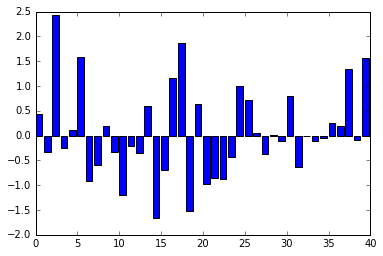

In [3]:
n_points = 40
x_vals = np.arange(n_points)
y_vals = np.random.normal(size=n_points)
plt.bar(x_vals, y_vals);

# The Gaussian kernel

The ‘kernel’ for smoothing, defines the shape of the function that is
used to take the average of the neighboring points. A Gaussian kernel
is a kernel with the shape of a Gaussian (normal distribution) curve.
Here is a standard Gaussian, with a mean of 0 and a $\sigma$ (=population
standard deviation) of 1.

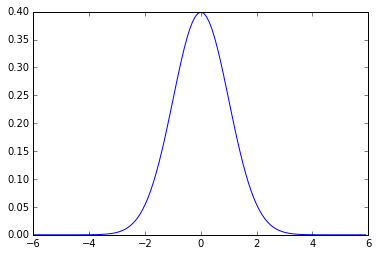

In [4]:
x = np.arange(-6, 6, 0.1) # x from -6 to 6 in steps of 0.1
y = 1 / np.sqrt(2 * np.pi) * np.exp(-x ** 2 / 2.)
plt.plot(x, y);

In the standard statistical way, we have defined the width of the Gaussian
shape in terms of $\sigma$. However, when the Gaussian is used for smoothing,
it is common for imagers to describe the width of the Gaussian with another
related measure, the Full Width at Half Maximum (FWHM).

The FWHM is the width of the kernel, at half of the maximum of the
height of the Gaussian. Thus, for the standard Gaussian above, the
maximum height is ~0.4.  The width of the kernel at 0.2 (on the Y axis) is the
FWHM. As x = -1.175 and 1.175 when y = 0.2, the FWHM is roughly 2.35.

The FWHM is related to sigma by the following formulae (in Python):

In [5]:
def sigma2fwhm(sigma):
    return sigma * np.sqrt(8 * np.log(2))

In [6]:
def fwhm2sigma(fwhm):
    return fwhm / np.sqrt(8 * np.log(2))

In our case:

In [7]:
sigma2fwhm(1)

2.3548200450309493

# Smoothing with the kernel

The basic process of smoothing is very simple. We proceed through the
data point by point. For each data point we generate a new value that is
some function of the original value at that point and the surrounding
data points.With Gaussian smoothing, the function that is used is our
Gaussian curve..

So, let us say that we are generating the new, smoothed value for the
14th value in our example data set. We are using a Gaussian with FWHM of
4 units on the x axis. To generate the Gaussian kernel average for this
14th data point, we first move the Gaussian shape to have its center at
13 on the x axis (13 is the 14th value because the first value is 0). In order
to make sure that we don’t do an overall scaling of the values after
smoothing, we divide the values in the Gaussian curve by the total area under
the curve, so that the values add up to one:

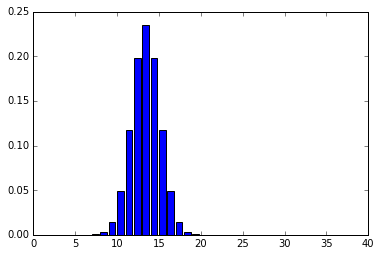

In [8]:
FWHM = 4
sigma = fwhm2sigma(FWHM)
x_position = 13 # 14th point
kernel_at_pos = np.exp(-(x_vals - x_position) ** 2 / (2 * sigma ** 2))
kernel_at_pos = kernel_at_pos / sum(kernel_at_pos)
plt.bar(x_vals, kernel_at_pos);

In fact the Gaussian values for the 12th through 16th data points are:

In [9]:
kernel_at_pos[11:16]

array([0.1174, 0.1975, 0.2349, 0.1975, 0.1174])

and the data values for the same points are:

In [10]:
y_vals[11:16]

array([-0.2049, -0.3588,  0.6035, -1.6648, -0.7002])

We then multiply the Gaussian kernel (weight) values by the values of our
data, and sum the results to get the new smoothed value for point 13:

In [11]:
y_by_weight = y_vals * kernel_at_pos # element-wise multiplication
new_val = sum(y_by_weight)
new_val

-0.3479685901184573

We store this new smoothed value for future use, and move on, to x = 14,
and repeat the process, with the Gaussian kernel now centered over 14.  If we
do this for each point, we eventually get the smoothed version of our original
data. Here is a very inefficient but simple way of doing this:

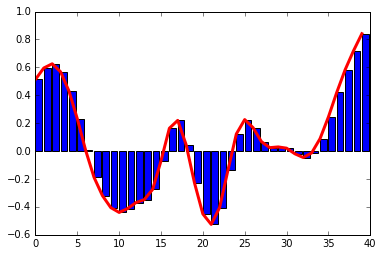

In [12]:
smoothed_vals = np.zeros(y_vals.shape)
for x_position in x_vals:
    kernel = np.exp(-(x_vals - x_position) ** 2 / (2 * sigma ** 2))
    kernel = kernel / sum(kernel)
    smoothed_vals[x_position] = sum(y_vals * kernel)
plt.bar(x_vals, smoothed_vals);
plt.plot(x_vals, smoothed_vals, lw=3, c='r');

### optimised version

120
40


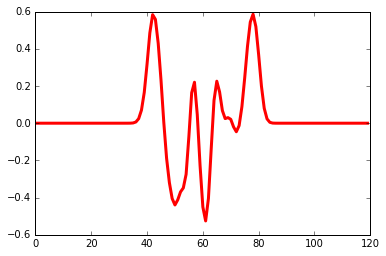

In [35]:
def gauss_kern(x, sigma):
    """ Returns a normalized 1D gauss kernel array for convolutions """
    size = len(x)    
    x = range(-size,size+1)
    g = 1.0/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-0.5*((x/sigma)**2))
    return g / g.sum()
# pl.figure()

FWHM=4
sigma = fwhm2sigma(FWHM)
win = gauss_kern(x_vals, sigma)
# plt.plot(win)
smoothed_signal = np.convolve(y_vals, win, mode='full')
# # plt.bar(x_vals, smoothed_signal);
plt.plot(smoothed_signal, lw=3, c='r');
print len(smoothed_signal)
print len(x_vals)

In [36]:
fwhm2sigma(5)

2.1233045007200477

# Other kernels

Of course, we could have used any shape for the kernel - such as a
square wave. A square wave kernel with sum set to one would would have the
effect of replacing each data point with the mean of itself and the
neighboring points.

# Smoothing as convolution

Smoothing can also be implemented and understood as *convolution* - see
[Smoothing as convolution](https://matthew-brett.github.io/teaching/smoothing_as_convolution.html) for an explanation.

# Smoothing in 2D

Smoothing in two dimensions follows simply from smoothing in one
dimension. This time the Gaussian kernel is not a curve, but a cone:

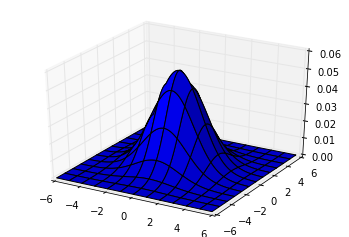

In [14]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
dx = 0.1
dy = 0.1
x = np.arange(-6, 6, dx)
y = np.arange(-6, 6, dy)
x2d, y2d = np.meshgrid(x, y)
kernel_2d = np.exp(-(x2d ** 2 + y2d ** 2) / (2 * sigma ** 2))
kernel_2d = kernel_2d / (2 * np.pi * sigma ** 2) # unit integral
ax.plot_surface(x2d, y2d, kernel_2d);

As for the 1D case, we can center this kernel to any point in a 2D plane, and
get the equivalent kernel values for each point on the plane.  Here is a 2D
Gaussian kernel centered at point (10, 10) on a size (20, 20) plane.  See the
page source for the code to make the figure:

We then proceed as before, multiplying the values of the kernel (as shown in
the figure above) by the data in the image, to get the smoothed value for that
point, and doing the same for every point on the image.

The procedure is the same for 3D data, except the kernel is rather more
difficult to visualize, being something like a sphere with edges that fade
out, as the cone fades out at the edges in the 2D case.

In fact, it turns out that we don’t have to generate these 2D and 3D versions
of the kernel for the computations, because we can get the same result from
applying a one dimensional smooth sequentially in the 2 or 3 dimensions. Thus,
for 2 dimensions, we could first smooth in the x direction, and then smooth
the x-smoothed data, in the y direction, This gives the same output as
applying the 2D kernel.

# Why smooth?

The primary reason for smoothing is to increase signal to noise.  Smoothing
increases signal to noise by the matched filter theorem. This theorem states
that the filter that will give optimum resolution of signal from noise is a
filter that is matched to the signal. In the case of smoothing, the filter is
the Gaussian kernel. Therefore, if we are expecting signal in our images that
is of Gaussian shape, and of FWHM of say 10mm, then this signal will best be
detected after we have smoothed our images with a 10mm FWHM Gaussian
filter.The next few images show the matched filter theorem in action. First we
can generate a simulated signal in a one dimensional set of data, by creating
a Gaussian with FWHM 8 pixels, centered over the 14th data point:

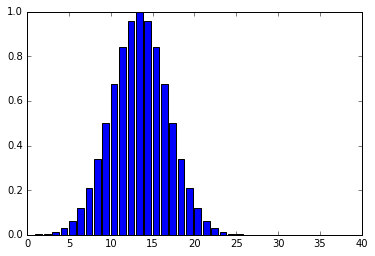

In [15]:
FWHM = 8
sigma = fwhm2sigma(FWHM)
x_position = 13 # 14th point
sim_signal = np.exp(-(x_vals - x_position) ** 2 / (2 * sigma ** 2))
plt.bar(x_vals, sim_signal);

Next, we add some random noise to this signal:

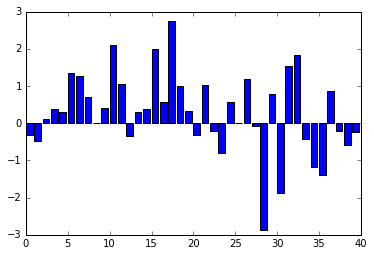

In [16]:
noise = np.random.normal(size=n_points)
sim_data = sim_signal + noise
plt.bar(x_vals, sim_data);

We then smooth with a matching 8 pixel FWHM filter:

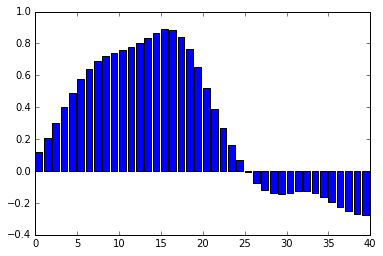

In [17]:
smoothed_sim_data = np.zeros(y_vals.shape)
for x_position in x_vals:
    kernel = np.exp(-(x_vals - x_position) ** 2 / (2 * sigma ** 2))
    kernel = kernel / sum(kernel)
    smoothed_sim_data[x_position] = sum(sim_data * kernel)
plt.bar(x_vals, smoothed_sim_data);

and recover our signal well from the noisy data.

Thus, we smooth with a filter that is of matched size to the activation we
wish to detect. This is of particular relevance when comparing activation
across subjects. Here, the anatomical variability between subjects will mean
that the signal across subjects may be expected to be rather widely
distributed over the cortical surface. In such a case it may be wiser to use a
wide smoothing to detect this signal. In contrast, for a single subject
experiment, where you want to detect (for example) a thalamic signal, which
may be in the order of a few mm across, it would be wiser to use a very narrow
smoothing, or even no smoothing.

# Finding the signal for any smoothing level

Sometimes you do not know the size or the shape of the signal change
that you are expecting. In these cases, it is difficult to choose a
smoothing level, because the smoothing may reduce signal that is not of
the same size and shape as the smoothing kernel. There are ways of
detecting signal at different smoothing level, that allow appropriate
corrections for multiple corrections, and levels of smoothing. This
Worsley 1996 paper describes such an approach: [Worsley KJ, Marret S,
Neelin P, Evans AC (1996) Searching scale space for activation in PET
images. Human Brain Mapping
4:74-90](http://www.math.mcgill.ca/~keith/scale/scale.abstract.html)

Matthew Brett (FB) 19/8/99, updated 26 October 2014